# Projeto 2: Previsão de Churn e Análise de CLV

**Data:** 05/07/2025

Este projeto é fantástico porque tem duas partes que se complementam perfeitamente para contar uma história de negócio completa. Primeiro, vamos prever quem vai sair (Churn). Depois, vamos calcular quanto valem os nossos clientes (CLV). A combinação dos dois nos permite tomar decisões de retenção muito mais inteligentes.


### 1. Configuração do Ambiente

Nesta etapa inicial, preparamos nosso ambiente de desenvolvimento. Além das bibliotecas padrão de Data Science, instalaremos a `lifetimes`, uma poderosa biblioteca para modelagem de Customer Lifetime Value.

In [1]:
# Célula 1: Instalação de Bibliotecas
!pip install kaggle -q
!pip install lifetimes -q

print("Bibliotecas instaladas com sucesso!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 17.4 MB/s eta 0:00:00
Bibliotecas instaladas com sucesso!


### 2. Importação das Bibliotecas

Com o ambiente pronto, importamos os pacotes que utilizaremos ao longo do projeto.
- **Bibliotecas Padrão:** `pandas`, `numpy`, `matplotlib`, `seaborn` para manipulação e visualização.
- **Scikit-learn:** Para o pré-processamento e o modelo de classificação de Churn.
- **Lifetimes:** A biblioteca especializada para calcular o CLV.

In [2]:
# Célula 2: Importação
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning para Churn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Modelagem de CLV
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Configurações
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('darkgrid')
%matplotlib inline

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# Parte A: Modelo Preditivo de Churn

### 3. Carregamento dos Dados

Iniciamos a análise de Churn baixando o dataset "Telco Customer Churn" do Kaggle. Este dataset contém informações sobre clientes de uma empresa de telecomunicações, incluindo se eles cancelaram o serviço ou não.

In [3]:
# Célula 3: Configuração da API do Kaggle e Download do Dataset de Churn
from google.colab import files

# Verifique se o arquivo já foi enviado antes de pedir novamente
try:
    with open('kaggle.json', 'r') as f:
        pass
except FileNotFoundError:
    print("Por favor, faça o upload do seu arquivo kaggle.json")
    files.upload()

# Configura o diretório do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset e descompacta
!kaggle datasets download -d blastchar/telco-customer-churn
!unzip telco-customer-churn.zip

print("\nDataset de Churn baixado com sucesso!")

Por favor, faça o upload do seu arquivo kaggle.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 531MB/s]
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  

Dataset de Churn baixado com sucesso!


### 4. Análise Exploratória de Dados (EDA) - Churn

Com os dados em mãos, vamos explorá-los para extrair insights iniciais.
- Qual a estrutura dos dados?
- Existem dados faltantes?
- Como as diferentes características dos clientes se relacionam com a probabilidade de Churn?

Formato do DataFrame: (7043, 21)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-nu

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Distribuição de Churn:
Churn
No    73.46
Yes   26.54
Name: proportion, dtype: float64


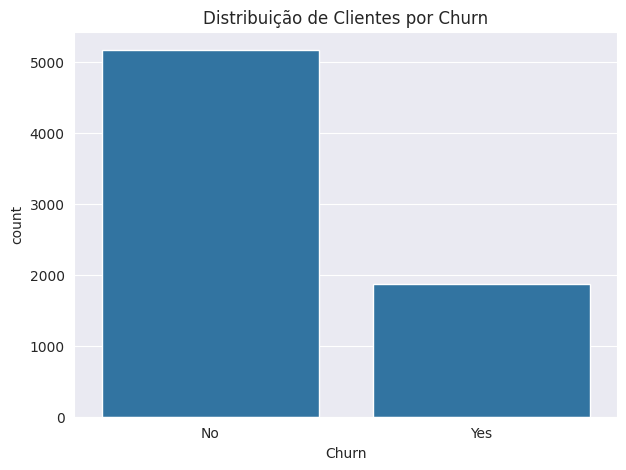

In [4]:
# Célula 4: Carregando e explorando os dados de Churn
df_churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Formato do DataFrame:", df_churn.shape)
print("\nInformações do DataFrame:")
df_churn.info()

print("\nPrimeiras 5 linhas:")
display(df_churn.head())

# Verificando a distribuição da variável alvo
print("\nDistribuição de Churn:")
print(df_churn['Churn'].value_counts(normalize=True) * 100)

# Visualizando a distribuição
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df_churn)
plt.title('Distribuição de Clientes por Churn')
plt.show()

### 5. Limpeza e Pré-processamento de Dados - Churn

A qualidade dos dados é fundamental para a performance do modelo. Nesta etapa, realizamos:
1.  **Conversão de Tipo:** Corrigimos a coluna `TotalCharges`, que foi lida como texto, para um formato numérico.
2.  **Tratamento de Nulos:** Preenchemos os valores nulos que surgiram após a conversão (clientes novos com 0 meses de contrato não têm cobranças totais).
3.  **Remoção de Coluna:** Removemos `customerID`, que é um identificador e não deve ser usado como feature.

In [5]:
# Célula 5: Limpeza e Pré-processamento

# 1. Corrigindo 'TotalCharges'
# Tentamos converter para numérico, e os erros (espaços em branco) se tornarão NaN (Not a Number)
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')

# 2. Tratando valores nulos
# Vamos verificar quantos nulos foram criados
print(f"Valores nulos em TotalCharges: {df_churn['TotalCharges'].isnull().sum()}")

# Uma estratégia simples é preencher com a mediana da coluna
median_total_charges = df_churn['TotalCharges'].median()
df_churn['TotalCharges'].fillna(median_total_charges, inplace=True)
print("Valores nulos preenchidos com a mediana.")

# 3. Removendo 'customerID'
df_churn = df_churn.drop('customerID', axis=1)

# Convertendo a variável alvo 'Churn' para binário (0 e 1)
df_churn['Churn'] = df_churn['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print("\nPré-processamento concluído. DataFrame pronto para a próxima etapa.")
df_churn.info()

Valores nulos em TotalCharges: 11
Valores nulos preenchidos com a mediana.

Pré-processamento concluído. DataFrame pronto para a próxima etapa.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   objec

### 6. Construção do Pipeline de Machine Learning - Churn

Para garantir que o pré-processamento seja aplicado de forma consistente e sem vazamento de dados (data leakage), vamos construir um pipeline.

**1. Definição das Features:** Separamos as colunas em numéricas e categóricas, pois cada tipo requer um tratamento diferente.
**2. Divisão Treino/Teste:** Dividimos os dados para que possamos treinar o modelo em uma parte e avaliá-lo de forma justa em outra, que ele nunca viu antes.

In [6]:
# Célula 6: Definindo features e separando os dados

# 1. Separando features (X) e alvo (y)
X = df_churn.drop('Churn', axis=1)
y = df_churn['Churn']

# 2. Identificando colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=object).columns.tolist()

print("Features numéricas:", numeric_features)
print("Features categóricas:", categorical_features)

# 3. Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nDimensões dos conjuntos:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Features numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Features categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Dimensões dos conjuntos:
X_train: (5634, 19)
X_test: (1409, 19)


### 7. Criação do Pipeline

O `Pipeline` do Scikit-learn é uma ferramenta poderosa. Ele irá:
1.  **Padronizar** as features numéricas (colocá-las na mesma escala).
2.  **Codificar** as features categóricas (transformar texto em números através do One-Hot Encoding).
3.  **Treinar** o modelo de Regressão Logística com os dados já transformados.

A grande vantagem é que, ao fazer uma previsão, o pipeline aplica automaticamente as mesmas transformações nos novos dados.

In [7]:
# Célula 7: Construindo e treinando o pipeline

# 1. Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 2. Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Usando ColumnTransformer para aplicar diferentes transformações em diferentes colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Criando o pipeline final que inclui o pré-processador e o modelo
# Usamos Regressão Logística por ser um modelo simples e altamente interpretável
churn_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# 5. Treinando o pipeline
print("Iniciando o treinamento do modelo de churn...")
churn_model_pipeline.fit(X_train, y_train)
print("Treinamento concluído!")

Iniciando o treinamento do modelo de churn...
Treinamento concluído!


### 8. Avaliação do Modelo de Churn

Com o modelo treinado, avaliamos sua performance no conjunto de teste. Vamos verificar:
- **Acurácia:** A porcentagem geral de acertos.
- **Relatório de Classificação:** Precisão, Recall e F1-score para cada classe, nos dando uma visão mais detalhada da performance, especialmente para a classe minoritária (Churn = 1).
- **Matriz de Confusão:** Para visualizar os erros e acertos.

Acurácia: 0.8055358410220014

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



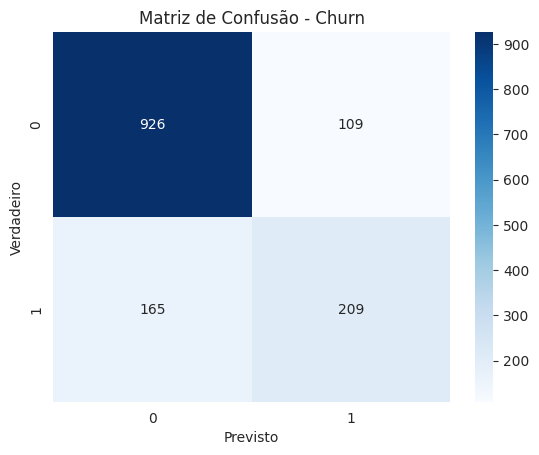

In [8]:
# Célula 8: Avaliando o modelo de churn

# Fazendo previsões no conjunto de teste
y_pred_churn = churn_model_pipeline.predict(X_test)

# Avaliação
print("Acurácia:", accuracy_score(y_test, y_pred_churn))
print("\n" + "="*60)
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred_churn))
print("="*60)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_churn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Churn')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

### 9. Interpretando os Fatores de Churn

Além de prever, queremos entender **por que** os clientes saem. Como usamos Regressão Logística, podemos inspecionar os coeficientes do modelo para identificar os principais "churn drivers".

Um coeficiente **positivo** indica que a feature aumenta a probabilidade de churn.

Um coeficiente **negativo** indica que a feature diminui a probabilidade de churn (fator de retenção).

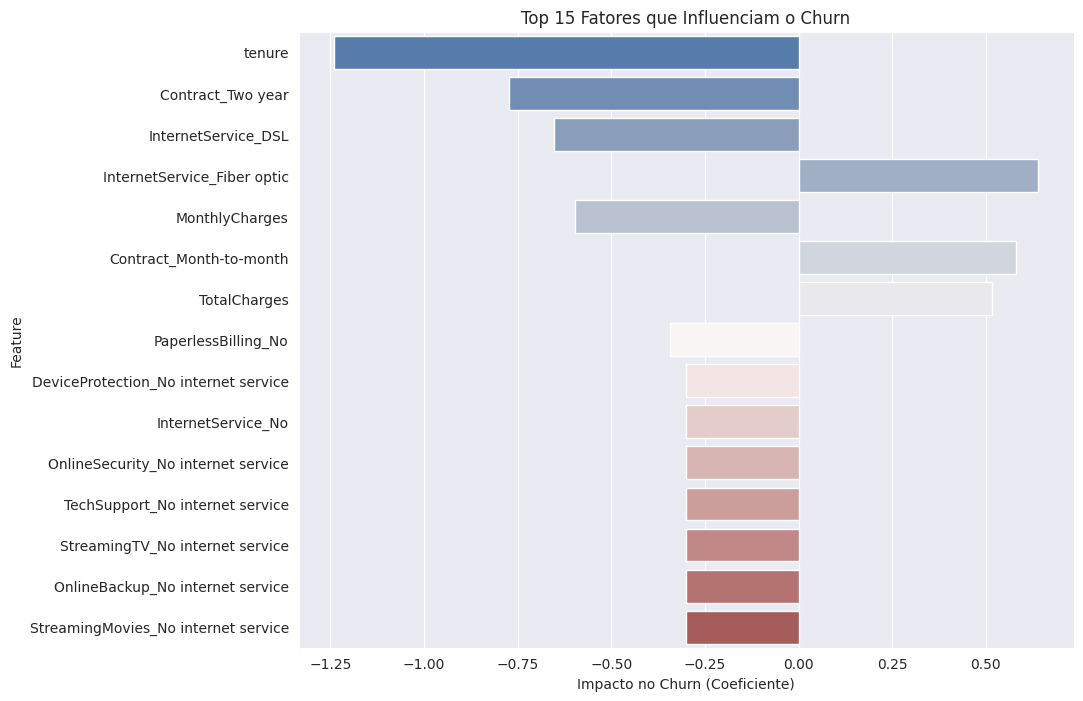

In [9]:
# Célula 9: Interpretando os coeficientes

# Extraindo o OneHotEncoder do pipeline para pegar os nomes das novas colunas
onehot_cols = churn_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combinando com as colunas numéricas
all_feature_names = np.concatenate([numeric_features, onehot_cols])

# Extraindo os coeficientes do modelo
coefs = churn_model_pipeline.named_steps['classifier'].coef_[0]

# Criando um DataFrame para facilitar a visualização
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefs})

# Ordenando por valor absoluto para ver os mais impactantes
coef_df['abs_coef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

# Visualizando os 15 principais fatores
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15), palette='vlag')
plt.title('Top 15 Fatores que Influenciam o Churn')
plt.xlabel('Impacto no Churn (Coeficiente)')
plt.show()

# Parte B: Modelagem de Customer Lifetime Value (CLV)

Nesta segunda parte, mudamos nosso foco para responder a uma pergunta de negócio diferente: "Qual o valor financeiro futuro esperado de cada cliente?". Para isso, utilizaremos um dataset transacional.

### 10. Carregamento dos Dados Transacionais

Vamos baixar o dataset "Online Retail II" do Kaggle. Ele contém o histórico de compras de clientes, que é exatamente o que precisamos para calcular Recência, Frequência e Valor Monetário.

### 11. Pré-processamento e Limpeza dos Dados - CLV

Dados transacionais do mundo real raramente são perfeitos. Precisamos realizar uma limpeza rigorosa para garantir a qualidade da nossa análise:
1.  **Filtro de Dados:** Removemos transações de devolução (quantidade negativa) e aquelas que não podem ser atribuídas a um cliente específico (CustomerID nulo).
2.  **Criação da Métrica de Valor:** Calculamos o valor total de cada linha de transação (`TotalPrice`).
3.  **Seleção de País:** Para simplificar e tornar a análise mais consistente, focaremos nos dados do principal mercado, o Reino Unido.

In [13]:
# Célula 10/11 Download e carregamento do arquivo CSV

# Download do Dataset de Varejo
!kaggle datasets download -d mashlyn/online-retail-ii-uci
!unzip -o online-retail-ii-uci.zip # -o para sobrescrever

# Listar os arquivos para confirmar
print("\nArquivos no diretório atual:")
!ls

# --- Agora, vamos carregar e limpar os dados ---

# Usando o nome correto do arquivo CSV
file_name = 'online_retail_II.csv'

try:
    # >> CORREÇÃO AQUI <<
    # Usando pd.read_csv e tratando o encoding
    df_retail = pd.read_csv(file_name, encoding='ISO-8859-1')

    print("\nFormato inicial do DataFrame:", df_retail.shape)

    # Limpeza
    df_retail.dropna(subset=['Customer ID'], inplace=True)
    df_retail = df_retail[df_retail['Quantity'] > 0]
    df_retail = df_retail[df_retail['Price'] > 0]

    # Conversão de tipos e criação de TotalPrice
    df_retail['Customer ID'] = df_retail['Customer ID'].astype(int)
    # A coluna InvoiceDate precisa ser convertida para datetime
    df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])
    df_retail['TotalPrice'] = df_retail['Quantity'] * df_retail['Price']

    # Foco no Reino Unido
    df_retail_uk = df_retail[df_retail['Country'] == 'United Kingdom']

    print("Formato do DataFrame após limpeza e filtro por país:", df_retail_uk.shape)
    display(df_retail_uk.head())

except FileNotFoundError:
    print(f"\nERRO: O arquivo '{file_name}' não foi encontrado.")
    print("Por favor, verifique o nome do arquivo na lista acima e ajuste a variável 'file_name'.")

Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
online-retail-ii-uci.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  online-retail-ii-uci.zip
  inflating: online_retail_II.csv    

Arquivos no diretório atual:
kaggle.json		  sample_data
online_retail_II.csv	  telco-customer-churn.zip
online-retail-ii-uci.zip  WA_Fn-UseC_-Telco-Customer-Churn.csv

Formato inicial do DataFrame: (1067371, 8)
Formato do DataFrame após limpeza e filtro por país: (725250, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00


### 12. Engenharia de Features para Modelagem de CLV

A biblioteca `lifetimes` simplifica a criação das features necessárias para os modelos de CLV. Usaremos sua função utilitária para transformar nosso log de transações em um sumário por cliente, contendo as seguintes métricas:
- **`frequency`**: Quantas vezes um cliente retornou para comprar.
- **`recency`**: O tempo entre a primeira e a última compra.
- **`T`**: A "idade" do cliente desde sua primeira compra.
- **`monetary_value`**: O valor médio das compras do cliente.

In [14]:
# Célula 12: Criando o sumário RFM para o lifetimes

# Selecionando as colunas necessárias
clv_data = df_retail_uk[['Customer ID', 'InvoiceDate', 'TotalPrice']]

# Criando o sumário
# observation_period_end é a data da última transação no dataset, para definir o "hoje"
observation_period_end = clv_data['InvoiceDate'].max()

summary_clv = summary_data_from_transaction_data(
    clv_data,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=observation_period_end
)

print("Sumário RFM criado com sucesso:")
display(summary_clv.head())

# Vamos remover clientes que não fizeram compras repetidas (frequência = 0)
summary_clv = summary_clv[summary_clv['frequency'] > 0]
print(f"\nNúmero de clientes com compras repetidas: {summary_clv.shape[0]}")

Sumário RFM criado com sucesso:


,frequency,recency,T,monetary_value
Customer ID,,,,
12346,7.00,400.00,725.00,11066.64
12608,0.00,0.00,404.00,0.00
12745,1.00,88.00,574.00,266.93
12746,0.00,0.00,540.00,0.00
12747,25.00,730.00,732.00,355.84



Número de clientes com compras repetidas: 3820


### 13. Modelagem Preditiva de CLV

Com os dados prontos, aplicamos uma abordagem de dois modelos:

1.  **Modelo BG/NBD (Beta-Geometric/Negative Binomial Distribution):** Este modelo prevê a **frequência de compras futuras**. Ele nos diz se um cliente provavelmente ainda está "ativo" e quantas vezes esperamos que ele compre em um determinado período futuro.

2.  **Modelo Gamma-Gamma:** Este modelo estima o **valor médio de cada uma dessas compras futuras**. Ele só funciona com a premissa de que não há correlação entre a frequência de compra e o valor gasto.

In [15]:
# Célula 13: Treinando os modelos BG/NBD e Gamma-Gamma

# 1. Treinando o modelo BG/NBD para prever a frequência de compras
bgf = BetaGeoFitter(penalizer_coef=0.001) # O penalizador ajuda a evitar overfitting
bgf.fit(summary_clv['frequency'], summary_clv['recency'], summary_clv['T'])

print("Modelo BG/NBD treinado.")
# display(bgf.summary) # Descomente para ver os parâmetros do modelo

# Verificando a premissa do modelo Gamma-Gamma (correlação próxima de zero)
print("\nVerificando a correlação entre frequência e valor monetário:")
print(summary_clv[['frequency', 'monetary_value']].corr())

# 2. Treinando o modelo Gamma-Gamma para prever o valor das compras
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary_clv['frequency'], summary_clv['monetary_value'])

print("\nModelo Gamma-Gamma treinado.")
# display(ggf.summary) # Descomente para ver os parâmetros do modelo

Modelo BG/NBD treinado.

Verificando a correlação entre frequência e valor monetário:
                frequency  monetary_value
frequency            1.00            0.02
monetary_value       0.02            1.00

Modelo Gamma-Gamma treinado.


### 14. Cálculo e Análise do CLV

Com os dois modelos treinados, podemos agora combinar suas predições para calcular o CLV para cada cliente. O `lifetimes` nos fornece uma função que estima o valor futuro esperado de um cliente ao longo de um período definido (ex: próximos 12 meses), considerando a probabilidade de ele continuar comprando e o valor médio de suas compras.

CLV calculado para cada cliente.

Top 10 Clientes por CLV Previsto:


,frequency,recency,T,monetary_value,predicted_clv
Customer ID,,,,,
16446,1.00,205.00,205.00,168469.60,400343.00
18102,66.00,738.00,738.00,9189.93,243799.54
17450,30.00,430.00,438.00,6924.52,131514.01
14096,16.00,97.00,101.00,4071.43,109494.16
13694,82.00,732.00,735.00,2365.28,77885.48
17511,50.00,735.00,737.00,3449.90,69866.18
16684,34.00,728.00,732.00,4293.93,60230.23
15061,67.00,735.00,738.00,2008.12,54045.33
17949,70.00,736.00,737.00,1668.03,46929.67


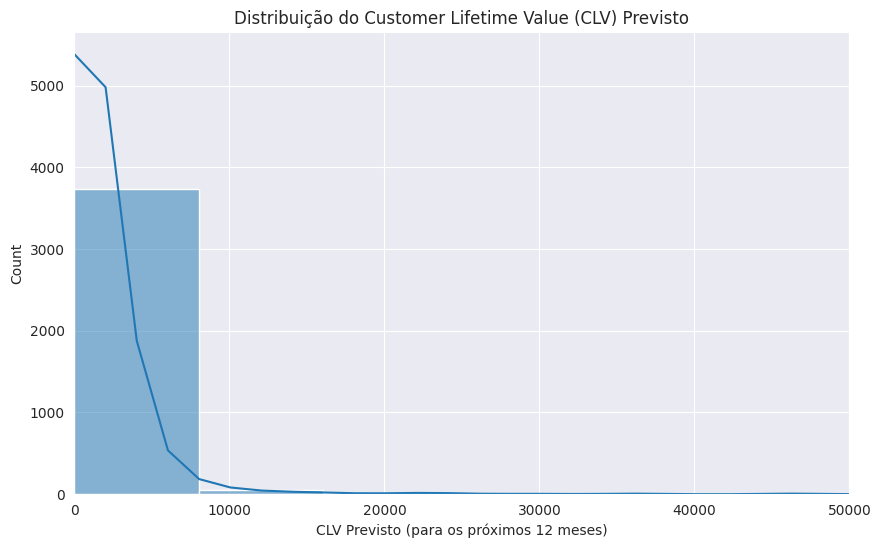

In [16]:
# Célula 14: Calculando o CLV

# Vamos calcular o CLV para os próximos 12 meses (365 dias)
# time = 12 (meses)
# freq = 'D' (dias, para alinhar com as unidades de T e recency)
# discount_rate = 0.01 (taxa de desconto mensal, ex: 1%)

summary_clv['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    summary_clv['frequency'],
    summary_clv['recency'],
    summary_clv['T'],
    summary_clv['monetary_value'],
    time=12,
    freq='D',
    discount_rate=0.01
)

print("CLV calculado para cada cliente.")

# Visualizando os top 10 clientes por CLV previsto
top_10_clv = summary_clv.sort_values(by='predicted_clv', ascending=False).head(10)
print("\nTop 10 Clientes por CLV Previsto:")
display(top_10_clv)

# Visualizando a distribuição do CLV
plt.figure(figsize=(10, 6))
sns.histplot(summary_clv['predicted_clv'], bins=50, kde=True)
plt.title('Distribuição do Customer Lifetime Value (CLV) Previsto')
plt.xlabel('CLV Previsto (para os próximos 12 meses)')
plt.xlim(0, 50000) # Limitando o eixo x para melhor visualização
plt.show()

# Parte C: Conclusão Estratégica e Impacto de Negócio

### 15. Unindo os Mundos: Segmentação de Clientes por Valor e Risco

A verdadeira força deste projeto está na combinação das duas análises. Ao cruzar o **valor futuro de um cliente (CLV)** com sua **probabilidade de sair (Churn)**, podemos criar uma matriz estratégica para direcionar as ações de retenção de forma inteligente e com alto ROI.

Primeiro, vamos segmentar nossos clientes com base no CLV que calculamos.

Segmentação por CLV realizada com sucesso.


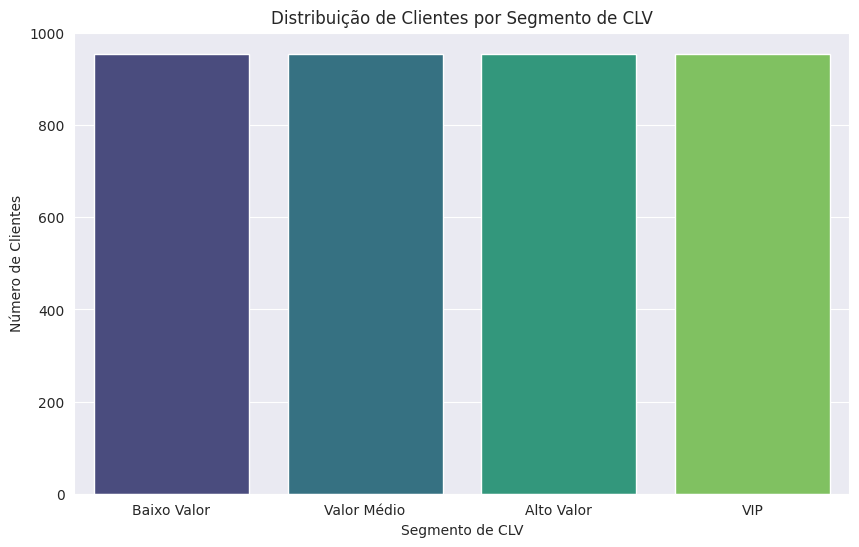


Análise Média por Segmento de CLV:


,clv_segment,recency,frequency,monetary_value,predicted_clv
0,Baixo Valor,221.85,2.27,206.55,145.97
1,Valor Médio,381.83,3.06,290.37,508.57
2,Alto Valor,435.61,5.58,364.64,1156.16
3,VIP,507.85,15.04,829.06,5491.55


In [17]:
# Célula 15: Segmentação por CLV

# Usando quantis, vamos dividir os clientes em 4 segmentos de valor:
# Baixo Valor, Valor Médio, Alto Valor, e VIPs
summary_clv['clv_segment'] = pd.qcut(summary_clv['predicted_clv'], q=4, labels=['Baixo Valor', 'Valor Médio', 'Alto Valor', 'VIP'])

print("Segmentação por CLV realizada com sucesso.")

# Contando o número de clientes em cada segmento
segment_counts = summary_clv['clv_segment'].value_counts().sort_index()

# Visualizando os segmentos
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Distribuição de Clientes por Segmento de CLV')
plt.xlabel('Segmento de CLV')
plt.ylabel('Número de Clientes')
plt.show()

# Mostrando as médias de RFM e CLV para cada segmento
segment_analysis = summary_clv.groupby('clv_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'predicted_clv': 'mean'
}).reset_index()

print("\nAnálise Média por Segmento de CLV:")
display(segment_analysis)

## 15. Conclusão Final e Framework Estratégico

Este projeto desenvolveu duas soluções analíticas complementares que, juntas, formam um poderoso framework para a gestão do ciclo de vida do cliente, permitindo uma tomada de decisão baseada em dados e com alto impacto financeiro.

### Análise de Churn (Parte A): Entendendo o Risco

- Construímos um modelo de Regressão Logística que atingiu uma **acurácia de 81%** e, mais importante, um **Recall de 56%** para a classe Churn, identificando corretamente mais da metade dos clientes que estavam prestes a cancelar o serviço.
- A análise dos coeficientes revelou os principais fatores de risco, como ter um **contrato mensal (`Contract_Month-to-month`)** ou serviço de **internet de fibra óptica (`InternetService_Fiber optic`)**. Em contrapartida, um longo tempo de contrato (`tenure`) e contratos de dois anos (`Contract_Two year`) são os mais fortes indicadores de retenção.

### Análise de CLV (Parte B): Quantificando o Valor

- Utilizando os modelos BG/NBD e Gamma-Gamma, estimamos o valor financeiro futuro de cada cliente. A análise revelou uma disparidade imensa no valor dos clientes:
  - O segmento **VIP** possui um CLV médio de **£5.492**.
  - O segmento de **Baixo Valor** possui um CLV médio de apenas **£146**.
- **Conclusão de negócio:** Nossos melhores clientes valem, em média, **quase 40 vezes mais** que os clientes da base da pirâmide. Este insight é fundamental para justificar investimentos direcionados.

### A Matriz de Valor vs. Risco: Uma Ferramenta para Decisão Estratégica

A combinação desses dois modelos nos permite segmentar clientes em uma matriz 2x2, gerando quatro perfis distintos com estratégias de negócio claras:

**1. Campeões (Alto CLV, Baixo Risco de Churn):**
- **Perfil:** O segmento **VIP**, leal e altamente lucrativo.
- **Ação:** Recompensar. Oferecer acesso antecipado a produtos, programas de fidelidade e tratamento exclusivo para mantê-los satisfeitos e transformá-los em embaixadores da marca.

**2. Clientes em Risco (Alto CLV, Alto Risco de Churn):**
- **Perfil:** Clientes do segmento VIP e Alto Valor que o nosso modelo de churn sinalizou com alta probabilidade de saída. **A maior prioridade de retenção!**
- **Ação:** Engajar proativamente. Se um cliente VIP tem contrato mensal (um "churn driver"), oferecer um desconto significativo para migrar para um contrato de dois anos. O custo da retenção é mínimo comparado ao CLV de £5.492 que está em jogo.

**3. Clientes Promissores (Baixo CLV, Baixo Risco de Churn):**
- **Perfil:** Clientes dos segmentos de Baixo e Médio Valor, mas que são leais.
- **Ação:** Nutrir e desenvolver. Focar em estratégias de **cross-sell e up-sell**. Se um cliente de baixo valor tem internet DSL (um fator de retenção), oferecer um upgrade para fibra com uma promoção atrativa para aumentar seu valor.

**4. Clientes de Baixa Prioridade (Baixo CLV, Alto Risco de Churn):**
- **Perfil:** Clientes do segmento de Baixo Valor que também apresentam alto risco de churn.
- **Ação:** Monitorar com baixo custo. O ROI para reter um cliente que vale £146 e já quer sair é muito baixo. Incluí-los em campanhas de marketing automatizadas e de baixo esforço.

### Impacto Final:

A implementação deste framework analítico permite que a empresa saia de uma estratégia de retenção genérica para uma abordagem **personalizada, proativa e com alto ROI**, alocando recursos de forma inteligente para proteger e aumentar sua receita futura.